<h1 align="center">Scientific Programming in Python</h1>
<h2 align="center">Topic 6: Python Profiling and Optimization  </h2> 


_Notebook created by Martín Villanueva - `martin.villanueva@usm.cl` - DI UTFSM - May 2017._

In [14]:
import numba
import numexpr as ne
import numpy as np
import matplotlib.pyplot as roberplot
import matplotlib.image as mpimg

%load_ext line_profiler
%load_ext memory_profiler

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

def image_plot(img):
    roberplot.figure(figsize=(10,5))
    roberplot.imshow(img, cmap='gray')
    roberplot.axis('off')
    roberplot.show()
    
def histogram_plot(h):
    roberplot.figure(figsize=(5,10))
    roberplot.plot(range(len(h)), h)
    roberplot.xlim([-5,260])
    roberplot.ylim([0,50000])
    roberplot.xlabel('Feature index')
    roberplot.ylabel('Number of repetitions')
    roberplot.grid()
    roberplot.show()

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler
The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


## Local Binary Pattern Representation

Local Binary Pattern (LBP) is a simple yet very efficient texture operator which labels the pixels of an image by thresholding the neighborhood of each pixel and considers the result as a binary number. 

Due to its discriminative power and computational simplicity, LBP texture operator has become a popular approach in various applications. 

Perhaps the most important property of the LBP operator in real-world applications is its robustness to monotonic gray-scale changes caused, for example, by illumination variations. Another important property is its computational simplicity, which makes it possible to analyze images in challenging real-time settings.

__Example of how LBP works:__
![image](data/lbp1.png)

__Type of features LBP compute:__
![image](data/lbp2.png)

Then, each pixel in the image is encoded as a 8-bit binary number (or its corresponding decimal representation) which represents a unique feature. With this representation we can make a histogram of the distribution of such features!

In [2]:
def lbp(region):
    """
    Region is a 3x3 ndarray
    """
    ret = (region >= region[1,1]).astype(int)
    return (2**7)*ret[0,0] + (2**6)*ret[0,1] + (2**5)*ret[0,2] + (2**4)*ret[1,2] + (2**3)*ret[2,2] + \
           (2**2)*ret[2,1] + (2**1)*ret[2,0] + (2**0)*ret[1,0]


def lbp_representation(image):
    """
    Compute lbp representation of image
    """
    m,n = image.shape
    ret = np.empty((m-2,n-2))
    for i in range(1,m-1):
        for j in range(1,n-1):
            ret[i-1,j-1] = lbp(image[i-1:i+2, j-1:j+2])
    return ret


def lbp_histogram(image):
    """
    Compute lbp histogram representation of image
    """
    lbp_image = lbp_representation(image)
    m,n = lbp_image.shape
    hist = np.zeros(256)
    for i in range(m):
        for j in range(n):
            a = lbp_image[i,j]
            hist[int(a)] += 1
    return hist 

## Just an example of usage

In [6]:
img = mpimg.imread('data/pancake.jpg')
img = rgb2gray(img)

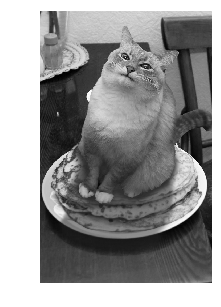

In [7]:
image_plot(img)

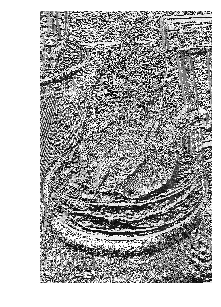

In [64]:
lbp_image = lbp_representation(img)
image_plot(lbp_image)

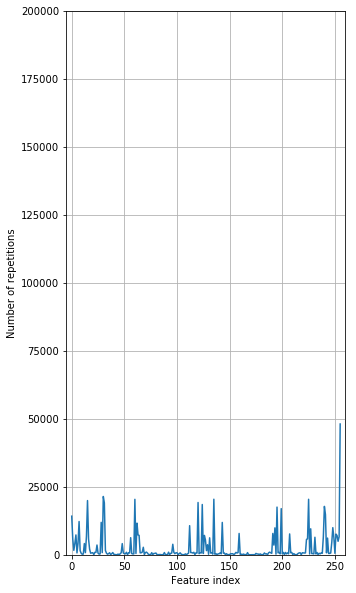

In [65]:
h = lbp_histogram(img)
histogram_plot(h)

## Problems
1. Profile the function `lbp_histogram()` with the profiling tools that you think are useful for this problem, and find the bottleneck(s).
2. Modify or implement new functions to fix such bottlenecks. You can use any of the tools learned so far (__NumPy, Numba, Cython, NumExpr, etc).__
3. Profile again (with your modifications) and verify that there exist improvements.

# Profile

### lbp_histogram

In [21]:
%%prun -s cumulative -q -l 15 -T prun1
h = lbp_histogram(img)

 
*** Profile printout saved to text file u'prun1'. 


In [22]:
print(open('prun1', 'r').read())

         1318388 function calls in 22.738 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000   22.738   22.738 <string>:2(<module>)
        1    1.455    1.455   22.738   22.738 <ipython-input-2-c5fccc52103f>:21(lbp_histogram)
        1    3.382    3.382   21.267   21.267 <ipython-input-2-c5fccc52103f>:9(lbp_representation)
   658168   15.115    0.000   17.869    0.000 <ipython-input-2-c5fccc52103f>:1(lbp)
   658168    2.755    0.000    2.755    0.000 {method 'astype' of 'numpy.ndarray' objects}
     2046    0.031    0.000    0.031    0.000 {range}
        1    0.000    0.000    0.000    0.000 {numpy.core.multiarray.zeros}
        1    0.000    0.000    0.000    0.000 {numpy.core.multiarray.empty}
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}


### Resultados

Podemos notar que las funciones que más tiempo llevan son lbp_representation y lbp. Analizaremos cada uno.

### lbp_representation

In [23]:
%lprun -T lprun1_rep -f lbp_representation lbp_representation(img)


*** Profile printout saved to text file u'lprun1_rep'. 


In [24]:
print(open('lprun1_rep', 'r').read())

Timer unit: 1e-06 s

Total time: 34.5069 s
File: <ipython-input-2-c5fccc52103f>
Function: lbp_representation at line 9

Line #      Hits         Time  Per Hit   % Time  Line Contents
     9                                           def lbp_representation(image):
    10                                               """
    11                                               Compute lbp representation of image
    12                                               """
    13         1            8      8.0      0.0      m,n = image.shape
    14         1           18     18.0      0.0      ret = np.empty((m-2,n-2))
    15      1023         1638      1.6      0.0      for i in range(1,m-1):
    16    659190      1616084      2.5      4.7          for j in range(1,n-1):
    17    658168     32889188     50.0     95.3              ret[i-1,j-1] = lbp(image[i-1:i+2, j-1:j+2])
    18         1            2      2.0      0.0      return ret


### lbp

In [25]:
%lprun -T lprun1_lbp -f lbp lbp(img[1:4,1:4])


*** Profile printout saved to text file u'lprun1_lbp'. 


In [26]:
print(open('lprun1_lbp', 'r').read())

Timer unit: 1e-06 s

Total time: 0.000107 s
File: <ipython-input-2-c5fccc52103f>
Function: lbp at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def lbp(region):
     2                                               """
     3                                               Region is a 3x3 ndarray
     4                                               """
     5         1           87     87.0     81.3      ret = (region >= region[1,1]).astype(int)
     6         1           20     20.0     18.7      return (2**7)*ret[0,0] + (2**6)*ret[0,1] + (2**5)*ret[0,2] + (2**4)*ret[1,2] + (2**3)*ret[2,2] +            (2**2)*ret[2,1] + (2**1)*ret[2,0] + (2**0)*ret[1,0]


# Optimization

In [4]:
@numba.jit('int64 (float64[:,:])', nopython=True)
def lbp2(region):
    """
    Region is a 3x3 ndarray
    """
    ret = (region > region[1,1])
    
    return (2**7)*ret[0,0] + (2**6)*ret[0,1] + (2**5)*ret[0,2] + (2**4)*ret[1,2] + (2**3)*ret[2,2] + \
           (2**2)*ret[2,1] + (2**1)*ret[2,0] + (2**0)*ret[1,0]

@numba.jit('float64[:,:] (float64[:,:])', nopython=True)
def lbp_representation2(image):
    """
    Compute lbp representation of image
    """
    m,n = image.shape
    ret = np.empty((m-2,n-2))
    for i in xrange(1,m-1):
        for j in xrange(1,n-1):
            ret[i-1,j-1] = lbp2(image[i-1:i+2, j-1:j+2])
    return ret

@numba.jit('float64[:] (float64[:,:])', nopython=True)
def lbp_histogram2(image):
    """
    Compute lbp histogram representation of image
    """
    lbp_image = lbp_representation2(image)
    m,n = lbp_image.shape
    hist = np.zeros(256)
    for i in range(m):
        for j in range(n):
            a = lbp_image[i,j]
            hist[int(a)] += 1
    return hist 

# Re-profile

In [110]:
%%prun -s cumulative -q -l 15 -T prun2
h = lbp_histogram2(img)

 
*** Profile printout saved to text file u'prun2'. 


In [111]:
print(open('prun2', 'r').read())

         3 function calls in 0.787 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.787    0.787 <string>:2(<module>)
        1    0.787    0.787    0.787    0.787 <ipython-input-109-ae68c3207435>:23(lbp_histogram2)
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}


In [90]:
%lprun -T lprun2 -f lbp_histogram2 lbp_histogram2(img)


*** Profile printout saved to text file u'lprun2'. 


In [87]:
print(open('lprun2', 'r').read())

Timer unit: 1e-06 s

Total time: 0 s
File: <ipython-input-72-6e2a9215d233>
Function: lbp_representation2 at line 11

Line #      Hits         Time  Per Hit   % Time  Line Contents
    11                                           @numba.jit('float64[:,:] (float64[:,:])', nopython=True)
    12                                           def lbp_representation2(image):
    13                                               """
    14                                               Compute lbp representation of image
    15                                               """
    16                                               m,n = image.shape
    17                                               ret = np.empty((m-2,n-2))
    18                                               for i in xrange(1,m-1):
    19                                                   for j in xrange(1,n-1):
    20                                                       ret[i-1,j-1] = lbp2(image[i-1:i+2, j-1:j+2])
    21          

# Resultados final

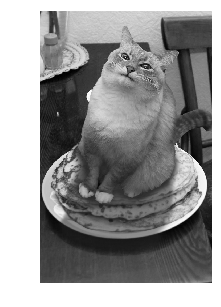

In [18]:
image_plot(img)

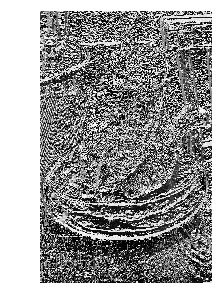

In [17]:
lbp_image = lbp_representation2(img)
image_plot(lbp_image)

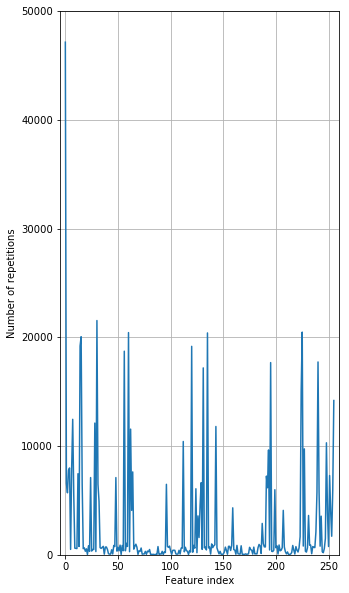

In [15]:
h = lbp_histogram2(img)
histogram_plot(h)